# Imports, loading features and DB

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap, get_froc_df_of_img, get_froc_df_of_many_imgs_features

import matplotlib.pyplot as plt

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train', 'validation'],
        extract_patches=False,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

# Classification

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [4]:
features_data, features_data_fns = pd.read_pickle('feature_sets/hough1_allEXChaar_1pxsize.pkl')

print(features_data.shape)
features_data.head()

(170722, 155)


,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_median,img_inter_quartile_range,...,patch_glcm_dissimilarity_HL1_0,patch_glcm_dissimilarity_HL1_1,patch_glcm_dissimilarity_HL1_2,patch_glcm_dissimilarity_HH1_0,patch_glcm_dissimilarity_HH1_1,patch_glcm_dissimilarity_HH1_2,candidate_coordinates,patch_coordinates,img_id,labels
0,95.993971,7.274124,0.006872,0.569024,0.609428,0.826936,0.880808,0.694805,0.657912,0.133249,...,7945.457143,7376.194444,7312.685714,68.428571,70.138889,66.057143,"[1168, 755, 19]","((748, 762), (1161, 1175))",20586908,True
1,50.194858,6.930837,0.009059,0.454882,0.474242,0.540236,0.620202,0.505097,0.501178,0.033165,...,5809.314286,5488.694444,6168.4,60.628571,62.25,61.771429,"[490, 2924, 7]","((2917, 2931), (483, 497))",20586908,True
2,37.193107,6.84277,0.010621,0.393939,0.40404,0.498148,0.564646,0.433845,0.41835,0.026684,...,11784.914286,11745.361111,11845.171429,84.114286,91.75,90.2,"[1075, 3017, 7]","((3010, 3024), (1068, 1082))",20586908,True
3,64.740718,7.067341,0.008122,0.49697,0.534343,0.619192,0.685859,0.573669,0.567845,0.036364,...,7918.742857,4995.388889,7941.542857,70.8,56.0,73.2,"[738, 602, 10]","((595, 609), (731, 745))",20586908,True
4,48.361328,6.908569,0.009319,0.442424,0.453872,0.587879,0.627946,0.49407,0.471044,0.046465,...,7870.142857,7609.972222,7860.142857,71.342857,67.972222,69.8,"[1036, 2774, 9]","((2767, 2781), (1029, 1043))",20586908,True


### TO DO:

**I. Cascade Classification**
1. Which features/classifiers are better to use on what stage. We'd like to know wich quick feature set can reduce number of candidates with retaining high sensitivity so we can in the next steps of cascade use more features (more complex ones) for detection?
    1. Feature extraction time by type
    2. False postivie reduction power with a goal for retaining 0.99 sensitivity

2. Build the cascaded classification. Show FP reduction and sensitivity changes of each step of cascade. Make it parametrized.
    1. Check if there is a point in using a cumulative set of features or only the new one.
    2. Check feature importances for each step of cascade.

3. Do hard negative mining. Use pool of negative samples to mine hard ones for every step of cascade training to get more robust classifiers.


**II. All features together Classification**

In [6]:
from xgboost import XGBRFClassifier

In [7]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_'in x]
wavelet_cols = [x for x in features_data if  x[:6] == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if  'haar' in x]
features_sets = {'fos':fos_cols, 'gabor':gabor_cols, 'wavelet':wavelet_cols,
                 'fos+gabor+wavelet+haar':fos_cols+gabor_cols+wavelet_cols+haar_cols}


In [8]:
# adding case_id column
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

### FIX 1
Dropping hough2 duplicates

In [9]:
# features_data_conv2str = features_data.drop(columns=features_sets['fos+gabor+wavelet+haar']).astype(str)
# print(len(features_data_conv2str))
# print(len(features_data_conv2str.drop_duplicates()))
# features_data = features_data[~features_data_conv2str.duplicated()]

### FIX 2
Considering original mask intersection

NOT A GOOD IDEA, IGNORE THIS CELL FOR NOW

In [10]:
# need to add SVC but a fast implementation or just wait a lot
classifiers = {'XGBRF': XGBRFClassifier(n_estimators=100, max_depth=6, n_jobs=-1),
               'RF': RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=-1),
               'SVC':SVC(C=10, probability=True)}


In [9]:
# features_data['raw_mask_intersection'] = 0
# for img_id in tqdm(db.df.img_id.unique()):
#     raw_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
#     for idx, row in features_data[features_data.img_id == img_id].iterrows():
#         (ppx1, ppx2), (ppy1, ppy2)= row['patch_coordinates']
#         features_data.at[idx, 'raw_mask_intersection'] = (raw_mask[ppx1:ppx2, ppy1:ppy2]>0).sum()

100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


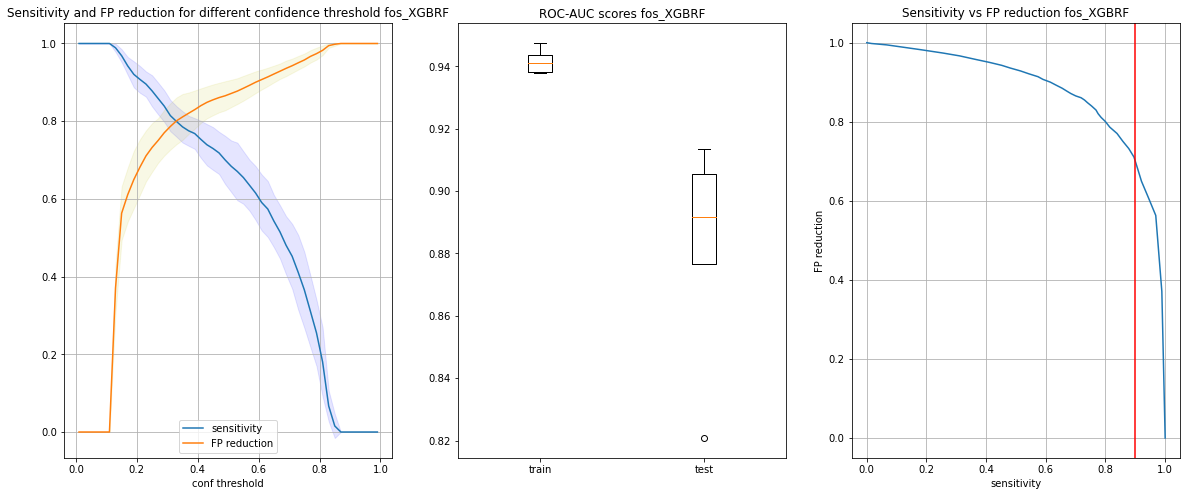

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


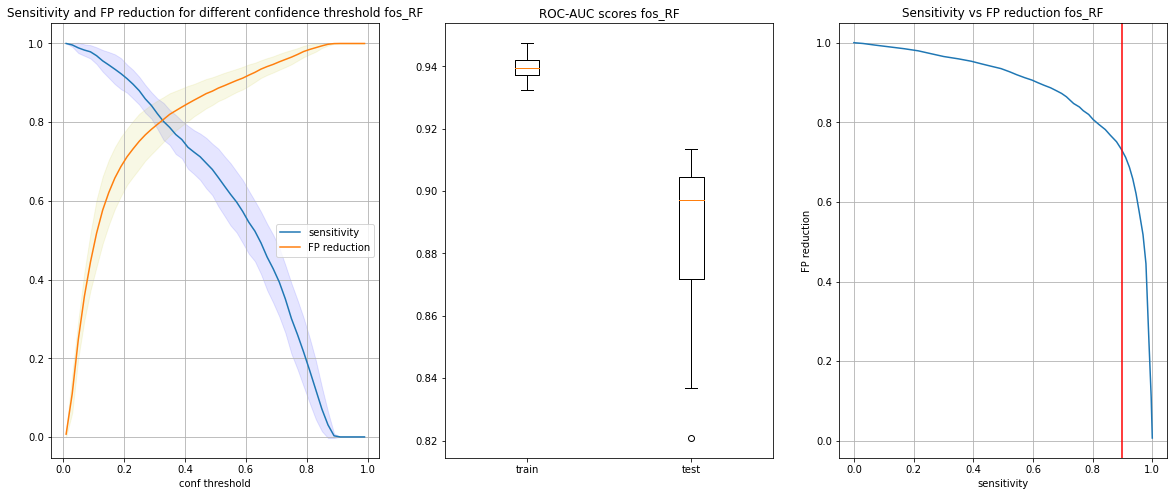

100%|██████████| 5/5 [01:56<00:00, 23.25s/it]


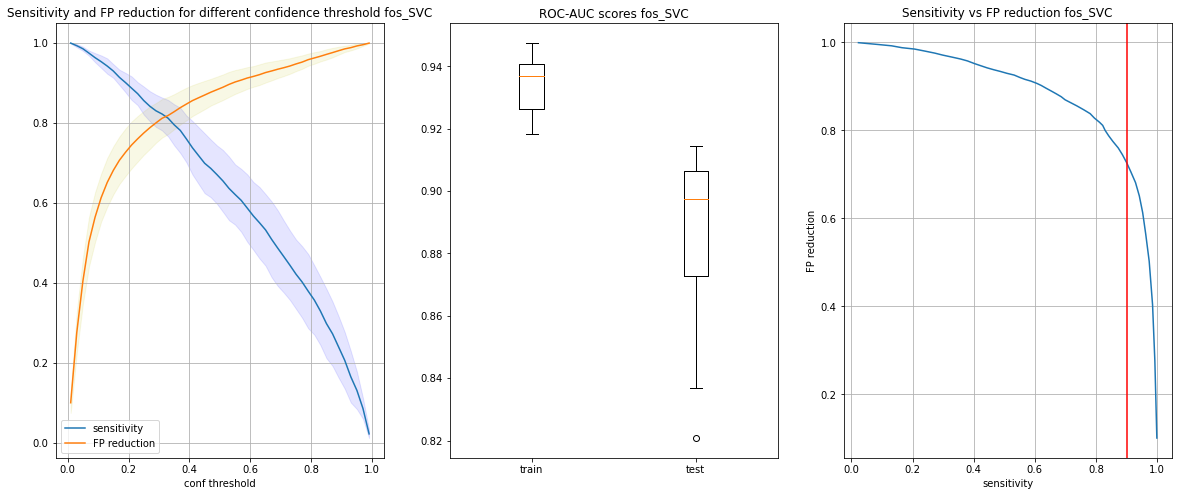

100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


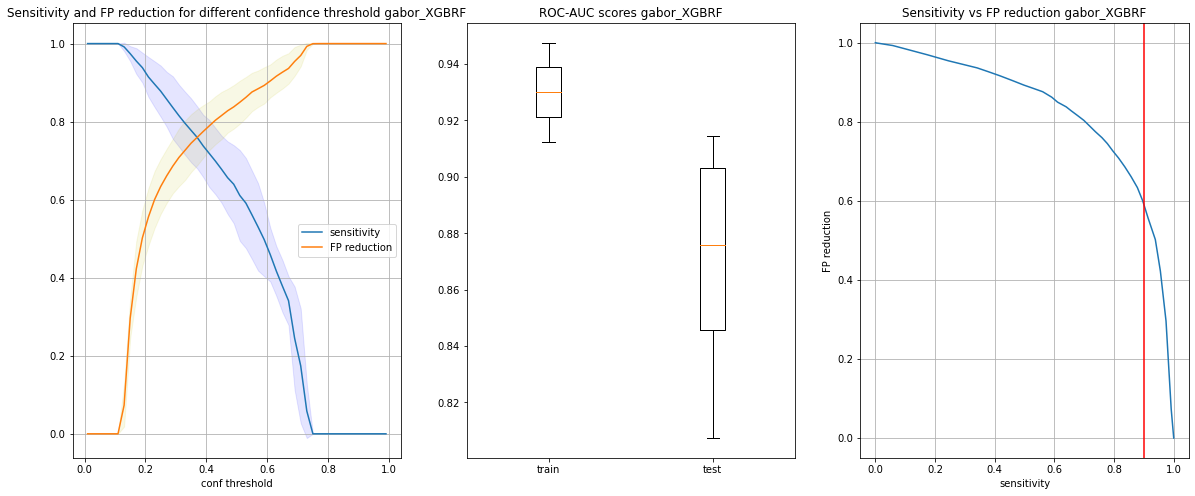

100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


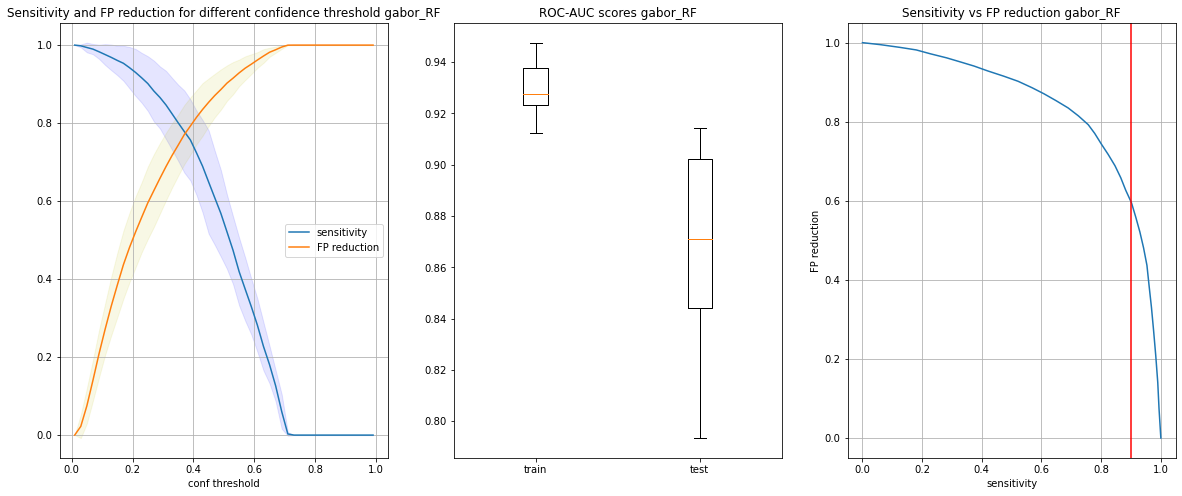

100%|██████████| 5/5 [02:25<00:00, 29.04s/it]


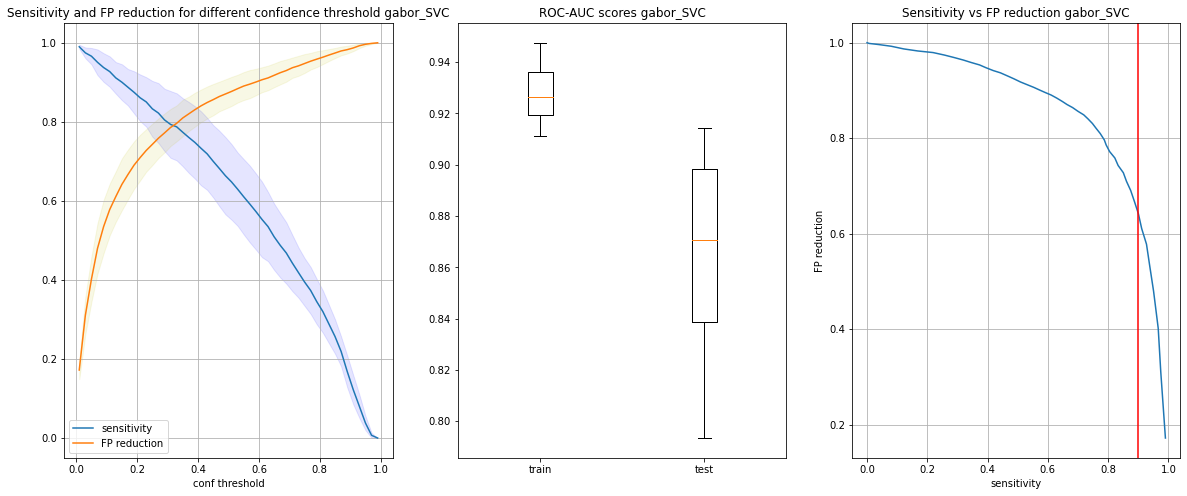

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


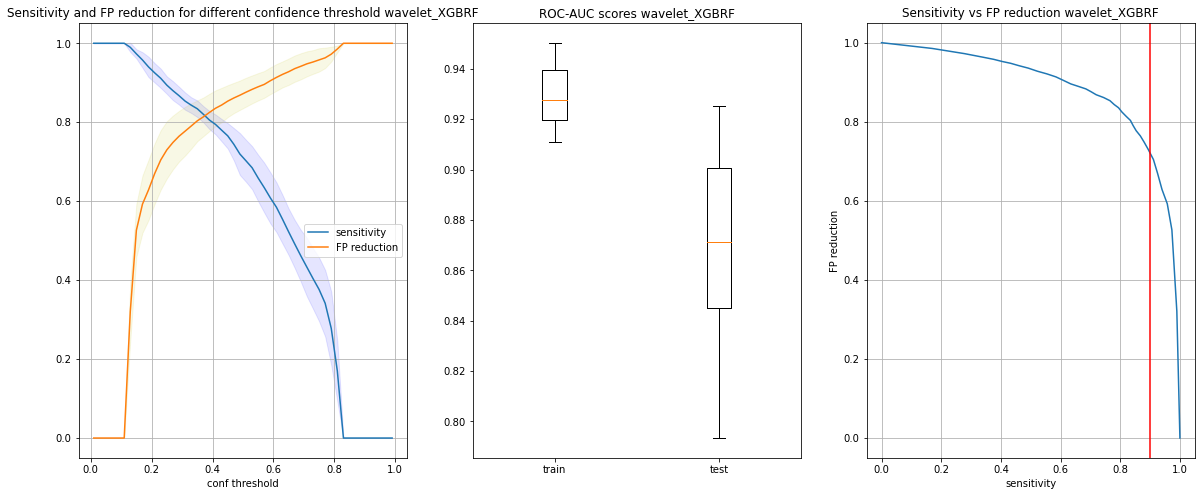

100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


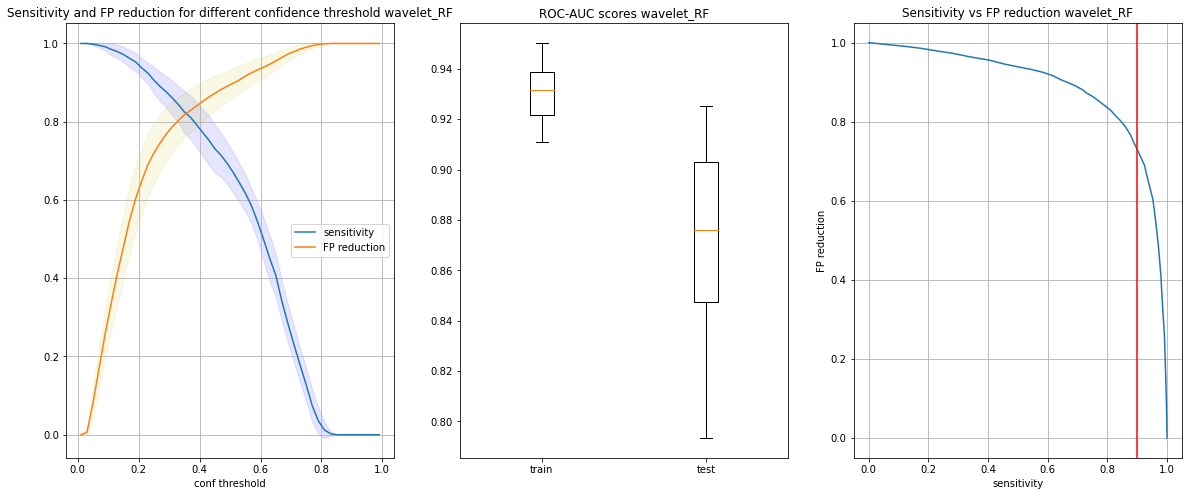

100%|██████████| 5/5 [03:02<00:00, 36.44s/it]


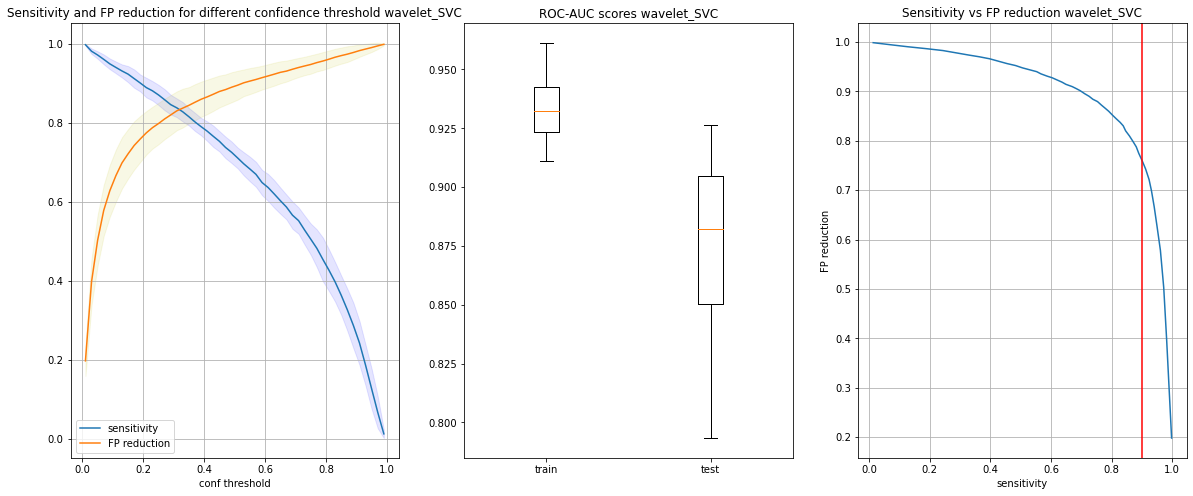

100%|██████████| 5/5 [01:07<00:00, 13.52s/it]


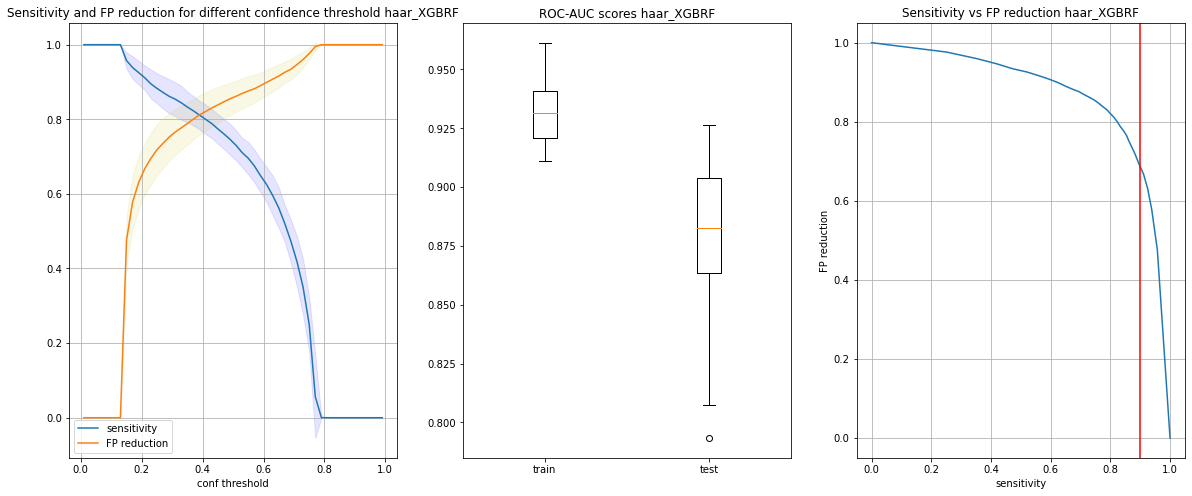

100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


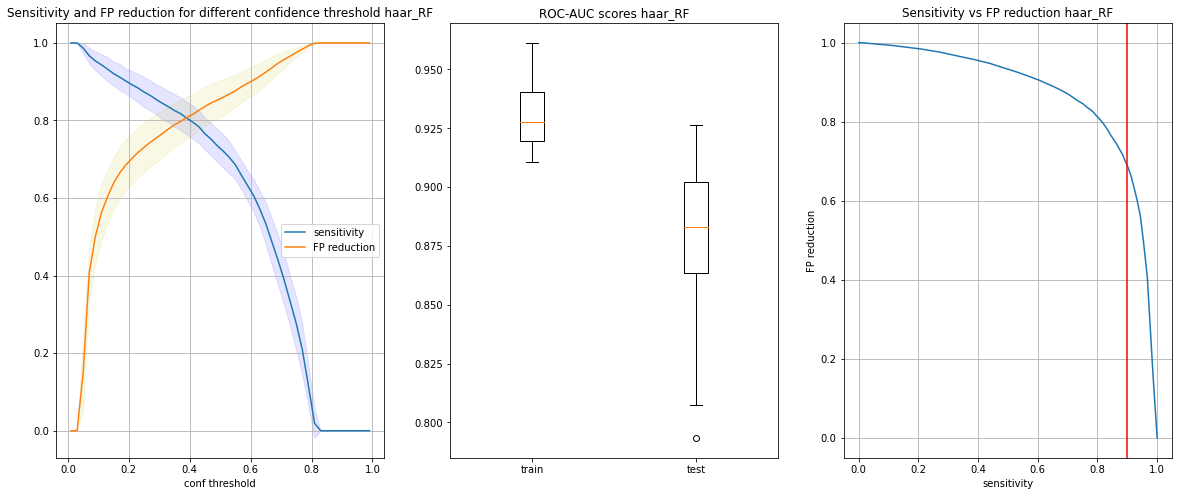

100%|██████████| 5/5 [11:59<00:00, 143.86s/it]


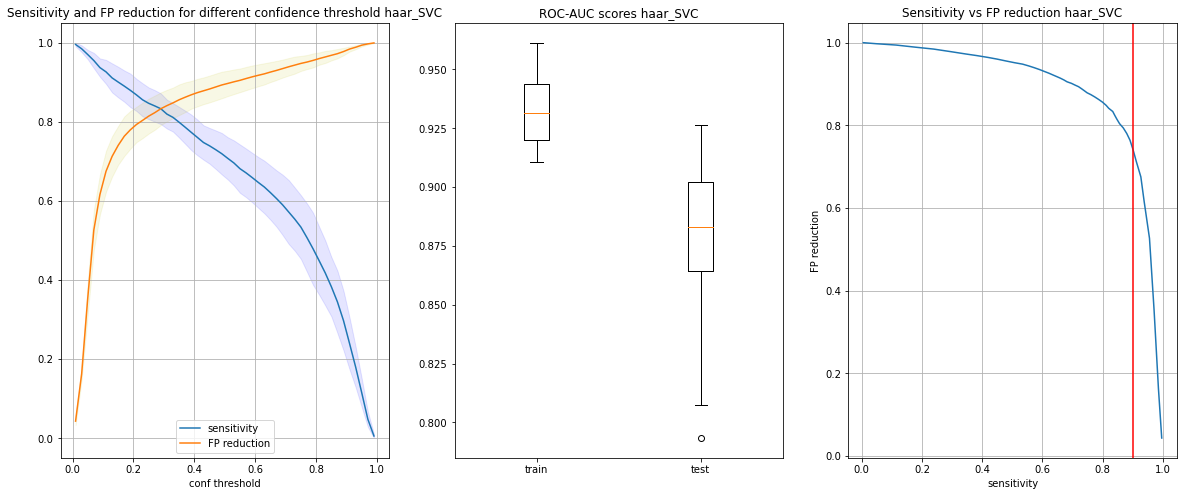

100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


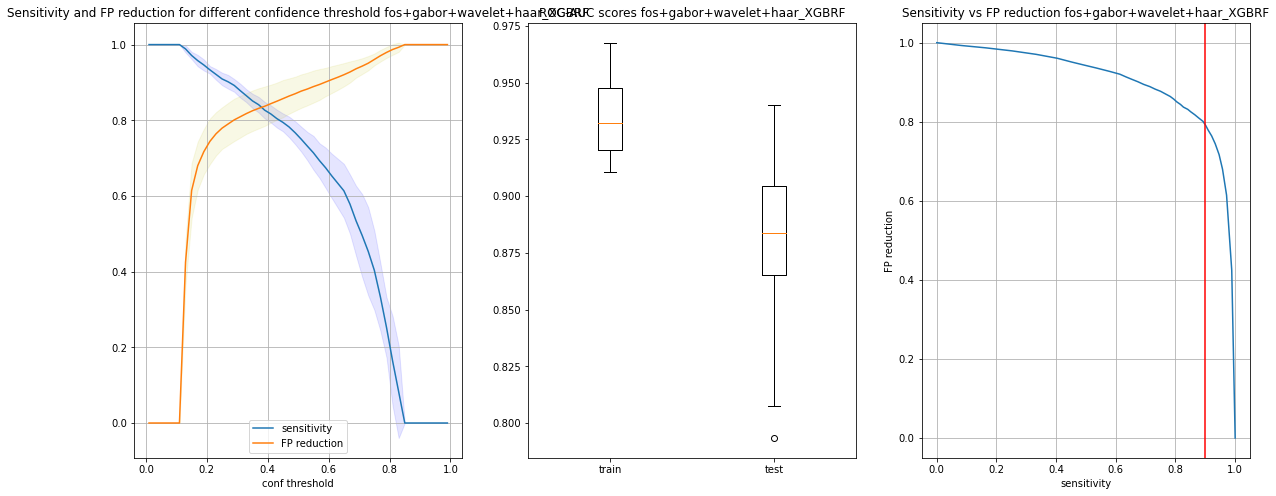

100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


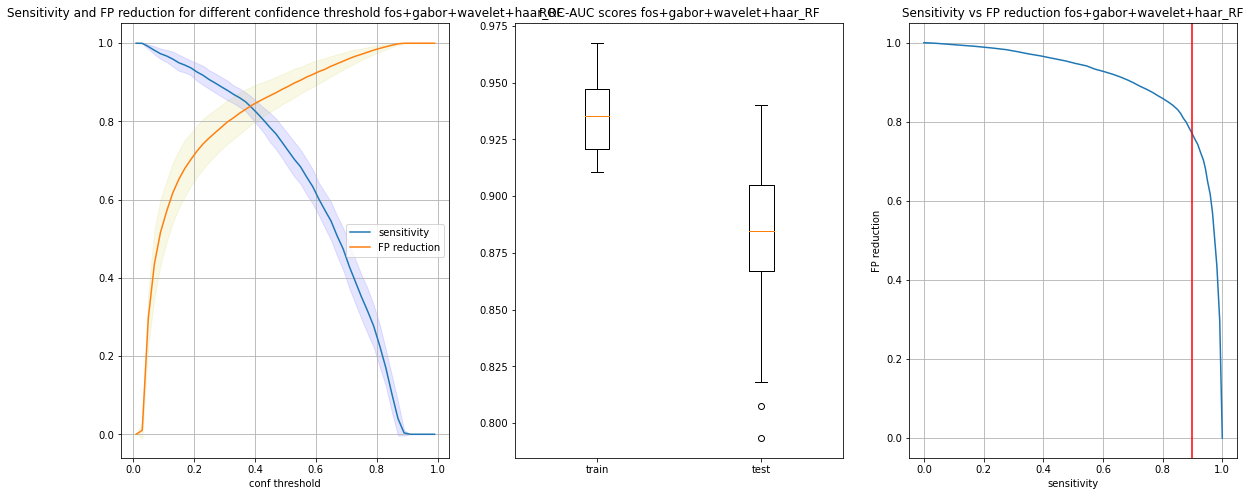

100%|██████████| 5/5 [13:09<00:00, 157.92s/it]


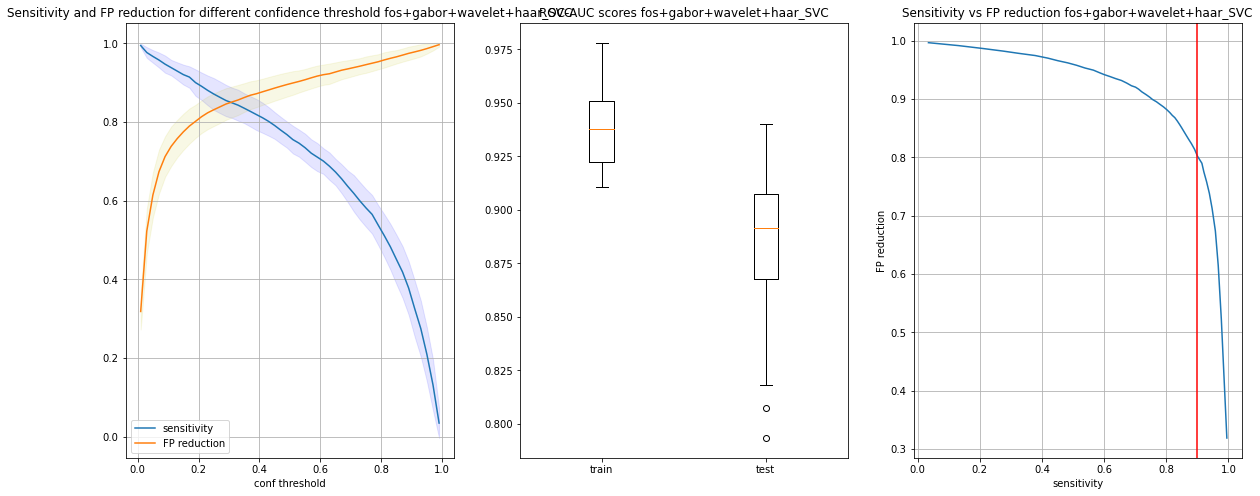

In [11]:
kfolds = 5
FP2TP_rate = 2
desired_sensitivity = 0.9

conf_thresholds = np.linspace(0.01, 0.99)

# splitting data into train/validation case-wise
all_case_ids = features_data.case_id.unique()
kfolds_case_splits = np.array_split(all_case_ids, kfolds)

roc_aucs = []


# classifiers = {'RF': RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1)}

results = {}

for feature_set_name, features_set in features_sets.items():

    for clf_name, clf in classifiers.items():
        
        fpr_sens_curve = []

        # kfold CV
        for valid_case_ids in tqdm(kfolds_case_splits):

            # split data into test
            test_split_mask = features_data.case_id.isin(valid_case_ids)
            
            # split into train and take into account cleaned data with no mC in the borders of the patch
            cleaned_features_data = features_data[~test_split_mask]
            
            # and sampling to a predefined 1:FP2TP_rate TP:FP samples
            positive_mask = (cleaned_features_data.labels>0)
            positive_train_part = cleaned_features_data[positive_mask]
            negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING
            
            train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
            
            
            
            test_df = features_data[test_split_mask]
            
            train_y = train_df.labels#.astype(int)
            test_y = test_df.labels#.astype(bool)
            
            scaler = MinMaxScaler()
            train_X_scaled = scaler.fit_transform(train_df[features_set].values)
            test_X_scaled = scaler.transform(test_df[features_set].values)
            
            clf.fit(train_X_scaled, train_y)

            train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
            test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]
            
            roc_aucs.append((roc_auc_score(train_y, train_y_predicted),
                            roc_auc_score(test_y, test_y_predicted)))
            
            sens_fpr = []
            for pred_thr in conf_thresholds:
                test_y_pred_binarized = (test_y_predicted>pred_thr).astype(bool)
                TP = (test_y & test_y_pred_binarized).sum()
                FN = (test_y & ~test_y_pred_binarized).sum()
                FP = (~test_y & test_y_pred_binarized).sum()
                max_FP_possible = (~test_y).sum()
                sens = TP/(TP + FN)
                sens_fpr.append((sens, 1 - FP/max_FP_possible))
                
            fpr_sens_curve.append(sens_fpr)

        # mean and std batch-wise of fpr and sensitivity
        fpr_sens_curve_mean = np.asarray(fpr_sens_curve).mean(axis=0)
        fpr_sens_curve_std = np.asarray(fpr_sens_curve).std(axis=0)


        fig, axs = plt.subplots(1, 3, figsize=(20, 8))

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,0])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,0]-fpr_sens_curve_std[:,0]), (fpr_sens_curve_mean[:,0]+fpr_sens_curve_std[:,0]), color='b', alpha=.1)

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,1])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,1]-fpr_sens_curve_std[:,1]), (fpr_sens_curve_mean[:,1]+fpr_sens_curve_std[:,1]), color='y', alpha=.1)

        axs[0].legend(['sensitivity', 'FP reduction'])
        axs[0].grid()
        axs[0].set_xlabel('conf threshold')
        axs[0].set_title(f'Sensitivity and FP reduction for different confidence threshold {feature_set_name}_{str(clf_name)}')

        axs[1].set_title(f'ROC-AUC scores {feature_set_name}_{str(clf_name)}')
        axs[1].boxplot(np.array(roc_aucs), labels=['train', 'test'])

        axs[2].plot(fpr_sens_curve_mean[:,0], fpr_sens_curve_mean[:,1])
        axs[2].set_xlabel('sensitivity')
        axs[2].set_ylabel('FP reduction')
        axs[2].set_title(f'Sensitivity vs FP reduction {feature_set_name}_{str(clf_name)}')
        axs[2].axvline(desired_sensitivity, c='r')
        axs[2].grid()

        plt.show()
        
        results[f'{feature_set_name}_{str(clf_name)}'] = fpr_sens_curve_mean


FP reduction show how many of the FP candidates were classified as negatives (aka reduction of FP)

### Final comparison graph

Text(0, 0.5, 'FP reduction')

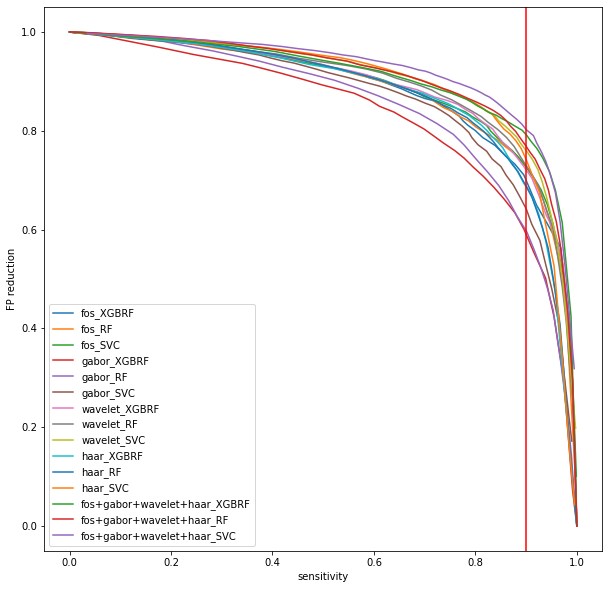

In [12]:
plt.figure(figsize=(10,10))

for fs, fs_res in results.items():
    plt.plot(fs_res[:,0], fs_res[:,1])

plt.axvline(desired_sensitivity, c='r')
plt.legend(results.keys())
plt.xlabel('sensitivity')
plt.ylabel('FP reduction')


## FROC Curve and final Metrics

In [15]:
FP2TP_rate = 4
features_set = features_sets['fos+gabor+wavelet+haar']

In [16]:
train_img_ids = db.df[db.df.partition == 'train'].img_id.values
validation_img_ids = db.df[db.df.partition == 'validation'].img_id.values


final_clf = classifiers['SVC']#XGBRFClassifier(n_estimators=100, max_depth=8, n_jobs=-1)

# split data into test
test_split_mask = features_data.img_id.isin(validation_img_ids)

# split into train and take into account cleaned data with no mC in the borders of the patch
cleaned_features_data = features_data[~test_split_mask]

# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = cleaned_features_data.labels
positive_train_part = cleaned_features_data[positive_mask]
negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING

print(f'FP:TP rate: {len(negative_train_part)/len(positive_train_part)}:1')

train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

test_df = features_data[test_split_mask]

train_y = train_df.labels
test_y = test_df.labels

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_df[features_set].values)
test_X_scaled = scaler.transform(test_df[features_set].values)

final_clf.fit(train_X_scaled, train_y)

train_y_predicted = final_clf.predict_proba(train_X_scaled)[:,1]
test_y_predicted = final_clf.predict_proba(test_X_scaled)[:,1]


train_df['confidence'] = train_y_predicted
test_df['confidence'] = test_y_predicted

FP:TP rate: 4.0:1


/tmp/ipykernel_331120/1802833442.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['confidence'] = test_y_predicted


In [17]:
train_fns_df = features_data_fns[features_data_fns.img_id.isin(train_img_ids)]

train_froc_df = get_froc_df_of_many_imgs_features(
    train_df[['candidate_coordinates', 'labels', 'img_id']],
    train_fns_df,
    train_y_predicted
)

sens, avgs_fp_per_image, _ = froc_curve(train_froc_df)
plot_froc(avgs_fp_per_image, sens, label='train')



test_fns_df = features_data_fns[features_data_fns.img_id.isin(validation_img_ids)]

test_froc_df = get_froc_df_of_many_imgs_features(
    test_df[['candidate_coordinates', 'labels', 'img_id']],
    test_fns_df,
    test_y_predicted
)

sens, avgs_fp_per_image, _ = froc_curve(test_froc_df)
plot_froc(avgs_fp_per_image, sens, label='test')

### Problems
1. ~~Duplicates in candidates, why?~~
2. Loss of labels in masks (including origianl masks) -> 22670177_lesion_mask.png
3. ~~Not properly saved labels in INBreast db from original mask (present in original not in one from the class) -> 20587174~~
4. ~~Mask labels are not exactly in the center of the patch (even though the mC is in the center, labeled roi is shifted) ->20587466~~
5. Pectoral muscle segmentation??? Some weird lines detection -> 22670147

In [16]:
bads_df = pd.concat([train_df, test_df]).sort_values(by=['confidence'], ascending=False).drop(columns=features_set)
bads_df = bads_df[~bads_df.labels]
bads_df

,candidate_coordinates,patch_coordinates,img_id,labels,case_id,confidence
12137,"[970, 1820, 4]","((1813, 1827), (963, 977))",22671003,False,f571fd4e63c718e3,0.995565
12136,"[970, 1819, 5]","((1812, 1826), (963, 977))",22671003,False,f571fd4e63c718e3,0.990936
12121,"[802, 1617, 4]","((1610, 1624), (795, 809))",22671003,False,f571fd4e63c718e3,0.986404
12127,"[804, 1618, 4]","((1611, 1625), (797, 811))",22671003,False,f571fd4e63c718e3,0.984304
7573,"[926, 1791, 3]","((1784, 1798), (919, 933))",22613624,False,dcafa6ba6374ec07,0.982683
...,...,...,...,...,...,...
6679,"[846, 2026, 13]","((2019, 2033), (839, 853))",22580098,False,6200187f3f1ccc18,0.000017
13995,"[896, 2908, 5]","((2901, 2915), (889, 903))",22679008,False,b9a4da5f2dae63a9,0.000011
15399,"[967, 2782, 11]","((2775, 2789), (960, 974))",24055328,False,1e10aef17c9fe149,0.000006
15774,"[534, 1354, 16]","((1347, 1361), (527, 541))",24055382,False,1e10aef17c9fe149,0.000005


<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


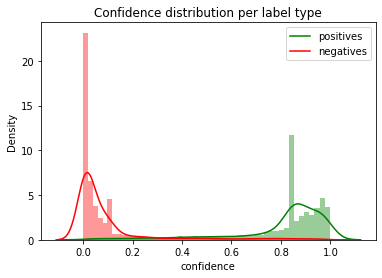

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


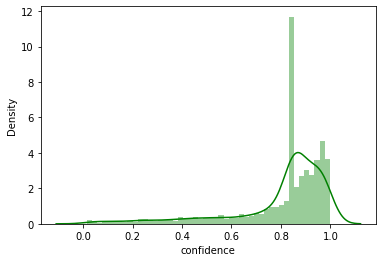

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


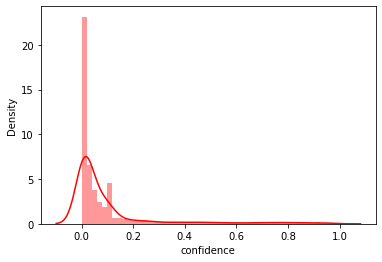

In [17]:
sns.distplot(train_df[train_df.labels].confidence, color='g')
sns.distplot(train_df[~train_df.labels].confidence, color='r')
plt.legend(['positives', 'negatives'])
plt.title('Confidence distribution per label type')
plt.show()

sns.distplot(train_df[train_df.labels].confidence, color='g')
plt.show()

sns.distplot(train_df[~train_df.labels].confidence, color='r')
plt.show()


In [ ]:

for _, bad_res in tqdm(bads_df.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    test_img_id = db.df[db.df.img_id == img_id].index.values[0] #((2767, 2781), (1029, 1043))	
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']
    original_test_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2)= bad_res['patch_coordinates']


    fig, axs = plt.subplots(4,3, figsize=(20, 8))

    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')

        axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
        axs[didx, 2].axis('off')
        axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_results/conf={bad_res["confidence"]}_{img_id}_{_}.jpg', bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)
    # plt.close(fig)

Two problems persist:
1. mC are labeled as big cluster
    * We need to consider clusters in INBreast db and let them pass size filter
2. mC are not labeled at all
    * Clustering and our labelling for clean pos/neg split used for final training